# Trabalhando com séries temporais e realizando predições de venda

O assunto mais comum dentro de data science com certeza é a predição. Isso não significa, no entanto, que ele não deva ser abordado.

Nesse texto, faremos uma predição de venda simples, utilizando uma série temporal. Esse tipo de análise está se tornando cada vez mais importante no mundo dos negócios, podendo ser aplicado até para a análise de concorrência.

Séries temporais são bjskfdns

## Mão na massa!

Nessa demonstração, iremos utilizar um conjunto de dados sobre preços de Abacate, disponível gratuitamente no Kaggle.

O notebook utilizado para fazer os códigos pode ser acessado aqui.

Primeiramente, iremos importar as bibliotecas e funções necessárias, e carregar nosso conjunto de dados por completo.

In [193]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.rcParams['agg.path.chunksize'] = 10000

datapath = './Augmented_avocado.csv'

In [194]:
df = pd.read_csv(datapath)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

df.head()

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,,
2015-01-04,28.110237,1.067238,8.694930e+05,729092.893820,25351.679256,660.521162,1.004203e+05,774572.742844,4584.245287,77.808862,conventional,2015.996867,Denver
2015-01-04,1.572266,1.182851,3.392160e+05,-7126.278994,6343.190422,1744.733838,9.164930e+04,52417.214688,64292.280389,-81.501851,conventional,2017.021296,RichmondNorfolk
2015-01-04,27.698464,1.010103,1.003913e+06,135920.046923,-10453.171511,38183.923925,1.283991e+06,33320.804223,32274.971967,23.954434,conventional,2016.015915,GrandRapids
2015-01-04,23.205972,2.037675,4.684201e+04,-10791.423866,-11870.226399,130.504001,5.344330e+03,-10284.410798,4903.903353,-71.976916,organic,2014.998154,NorthernNewEngland
2015-01-04,43.915310,2.631752,-2.936871e+04,-8290.207744,-29400.868245,825.060689,-5.818334e+03,1083.105122,1356.634473,-116.180783,organic,2016.011704,WestTexNewMexico


In [195]:
color_list = ['#1481c1', '#f12553']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

Temos várias informações nesse conjunto de dados que não iremos utilizar para nossa análise. Vamos então limpar esse dataframe e ficar apenas com os dados da média dos preços. 

Também temos vários valores para um mesmo dia, que variam de acordo com a localização, mas essa relação não é de nosso interesse. Então iremos fazer a média desses dados, agrupando-os pela data.

Assim, obtemos a base disposta abaixo, que utilizaremos para fazer a predição de vendas.

In [196]:
df = df.groupby('Date')['AveragePrice'].mean().to_frame()
df.head()

,AveragePrice
Date,
2015-01-04,1.393442
2015-01-11,1.380804
2015-01-18,1.452548
2015-01-25,1.279154
2015-02-01,1.327422


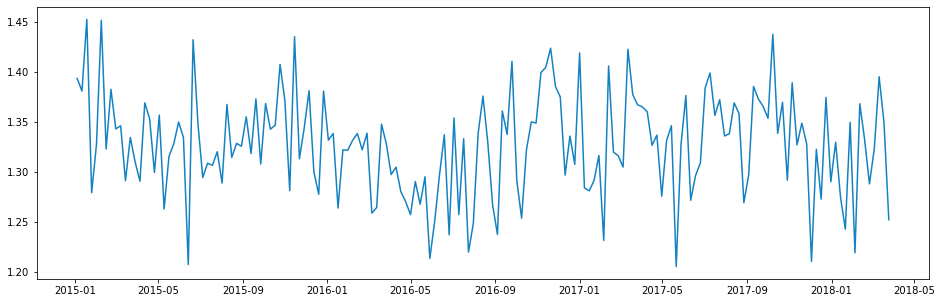

In [197]:
plt.figure(figsize=(16, 5))
plt.plot(df)

### Separando a base de treino

Como em qualquer projeto de machine learning, é interessante que o conjunto de dados seja dividido entre uma base de treino e uma base de teste, para validarmos a eficácia do modelo.

Então, iremos formar uma base de treino com os 152 primeiros valores do nosso conjunto inicial (aprox. 90%) e o restante deixaremos em uma base de teste.

A seguir podemos ver o resultado gráfico dessa separação.

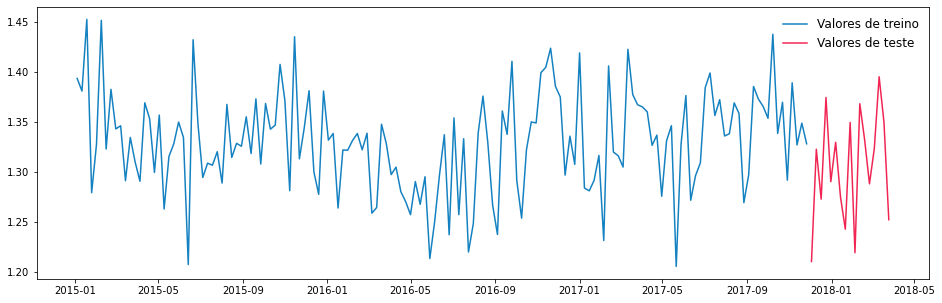

In [198]:
train = df.iloc[:152,0].to_frame()
test = df.iloc[152:169,0].to_frame()

plt.figure(figsize=(16, 5))
plt.plot(train)
plt.plot(test)
plt.legend(['Valores de treino','Valores de teste'], fontsize='large',frameon=False)

### Analisando a série temporal

As séries temporais possuem diversas características que podem afetar a modelagem, como a sazonalidade, a tendência e a estacionariedade.

No entanto, apenas com a representação gráfica acima não conseguimos avaliar essas características no nosso conjunto de dados. Por isso, utilizaremos o recurso visual da decomposição sazonal e o teste de Dickey Fuller, que nos indicará estatísticamente se nossa série é estacionária ou não.

Abaixo, temos a decomposição sazonal do nosso conjunto de dados. Nesses gráficos, conseguimos observar tanto a tendência quanto a sazonalidade da série.

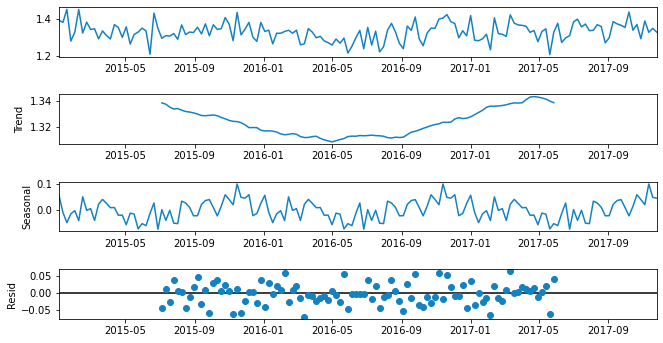

In [199]:
decomposition = sm.tsa.seasonal_decompose(train, model='additive')
fig = decomposition.plot()
fig.set_size_inches(10,5)
plt.show()

Observando esses resultados, é possível notar uma leve tendência de queda e vemos uma certa sazonalidade também. No entanto, é importante termos resultados mais objetivos e diretos para analisar se nossa base está adequada para a modelagem.

Para isso, utilizaremos o teste de Dickey Fuller. Com base no p-value saberemos se a série é estacionária ou não.

In [200]:
adf_results = adfuller(train)

print('Teste Dickey-Fuller: %f' % adf_results[0])
print('p-value: %f' % adf_results[1])
print('Valores críticos:')
for key, value in adf_results[4].items():
    print('\t%s: %.4f' % (key, value))    

Teste Dickey-Fuller: -4.163590
p-value: 0.000759
Valores críticos:
	1%: -3.4753
	5%: -2.8813
	10%: -2.5773


Nesse caso, nossa série já é estacionária.

### Modelagem

Uma das formas mais comuns de modelar séries temporais é com o modelo ARIMA, que envolve:
* AR: autocorrelação
* I: integração (da diferenciação)
* MA: moving average

Ele é calculado com base em parâmetros (p,d,q), definidos de acordo com os critérios acima.    

A diferenciação de um modelo é geralmente utilizada quando ele não é estacionário. 
Nosso modelo já é estacionário, então não precisamos aplicar a diferenciação. 

Assim, não utilizaremos o parâmetro d. Assim nos resta um modelo ARMA, também bastante utilizado.

Vamos analisar então a autocorrelação do modelo, utilizando funções da biblioteca statsmodel.


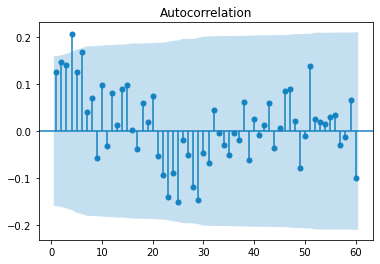

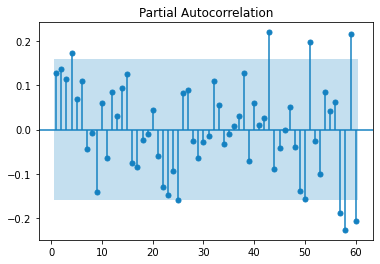

In [201]:
plot_acf(train, lags=60, zero=False);
plot_pacf(train, lags=60, zero=False);

Observando os gráficos, vemos que não temos uma correlação muito discrepante. Assim não considerariamos nenhum lag no nosso parâmetro p da modelagem ARMA.

Então nossos primeiros parâmetros seriam nulos, nos restando uma modelagem por Moving Average (MA). Vamos implementá-la a seguir.


O pandas já nos fornece uma função que facilita o cálculo da média móvel. Podemos aplicá-la na nossa base de treino, e verificar o resultado, considerando as últimas 4 semanas.

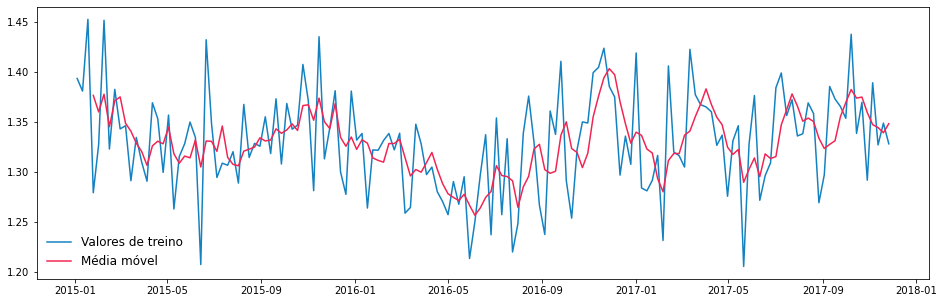

In [202]:
plt.figure(figsize=(16, 5))
plt.plot(train)
plt.plot(train.rolling(4).mean())
plt.legend(['Valores de treino','Média móvel'],fontsize='large',frameon=False)

No entanto, nosso objetivo é fazer com que o modelo preveja os dados futuros. Vamos aplicar a média móvel na base de teste para validar essa modelagem.

Note que os primeiros valores consideram os dados da base de treino, já que o cálculo é feito com base no histórico. Conforme vamos construindo os dados de previsão, eles passam a ser usados para o cálculo da média móvel.

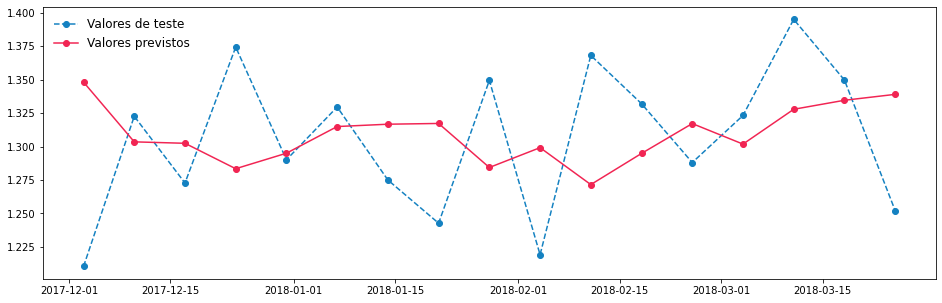

In [211]:
## aplicando a modelagem de médias móveis na base de teste

def moving_average(n, train_data, test_data):
    data = [train_data.iloc[i,0] for i in range(len(train_data))]
    predicted = []
    for j in range(len(test_data)):
        mean = np.mean(data[-n:])
        prices = test_data.iloc[j,0]
        predicted.append(mean)
        data.append(prices)
    return predicted

test['Predicted'] = moving_average(4, train, test)

plt.figure(figsize=(16, 5))
plt.plot(test.AveragePrice, 'o--')
plt.plot(test.Predicted, 'o-')
plt.legend(['Valores de teste','Valores previstos'],frameon=False,fontsize='large')

In [213]:
mae = mean_absolute_error(test.AveragePrice,test.Predicted)
mse = mean_squared_error(test.AveragePrice,test.Predicted)
mape = np.mean(abs(test.AveragePrice.values - test.Predicted.values)/test.AveragePrice.values)*100

print('MAE: %f' % mae)
print('MAPE: %f' % mape)
print('MSE: %f' % mse)

MAE: 0.053665
MAPE: 4.150075
MSE: 0.004180


In [212]:
# test.AveragePrice.std()
# test.Predicted.std()
# test.AveragePrice.values